In [1]:
import sys
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021/Functions')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/Functions_2022')
sys.path.append('/exports/csce/datastore/geos/users/s2110831/out')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import os
import pathlib
import xarray as xr
import pandas as pd
import json
from pyasdf import ASDFDataSet
import h5py
import cmcrameri as cmm
from scipy import signal

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

In [4]:
# Import own functions
from vel_rho_Q_models import *
from FCT_plotting import *
from FCT_BP_filter_loop import BP_filter
from FCT_3D_gradients import dttv, _1st_DER, _2nd_DER, ROT_2nd_DER
from FCT_laplacian import *
from FCT_WaveEquations import *
from FCT_Normal_Solution import *
from FCT_objective import *
from FCT_LinearRegression import *
from FCT_MISFIT_WaveEquations import *

--> Server: 'https://l.mondaic.com/licensing_server', User: 'marthe.faber', Group: 'UniversityOfEdinburgh'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.52 seconds]


In [5]:
colors = ['ivory',"wheat",'burlywood','tab:brown']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
my_cmap = cmap1
#mpl.rc('image', cmap=my_cmap)
plt.rcdefaults()


In [6]:
palette = sns.color_palette("YlGnBu", 10).as_hex()
ccc=['#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d']
YlGnBu=LinearSegmentedColormap.from_list("mycmap", ccc)

In [7]:
colors = ['white','whitesmoke','lightyellow','#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d', '#1d2e83','midnightblue']
nodes = [0.0,0.05,0.15,0.2,0.25,0.32,0.38,0.42, 0.46,0.5,0.57,0.7,0.8,1.0] #0.8
cmap4 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

## Project 

In [195]:
output = '/exports/csce/datastore/geos/users/s2110831/'

# Load an existing project.
project_name = '3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8elHOM_SAMEDIR'#'3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el_SAME'#'3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8elHOM_mean2'#'3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8elHOM_mean' #'3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el'#'3DELASTIC_HOM600x300_HET_abs2_4el_test2_hetZ_ACTIVEii_LARGER-'#8el'

event_name = "src_loc_c_isotropic_FS_src_SURF"
model ='acoustic'

In [196]:
# Read data from file:
path_ev = str(output)+"out/"+str(project_name)+"/EVENTS/"+str(event_name)
fig_ = str(path_ev)+'/FIGURES'
para_ = str(path_ev)+'/PARAMETERS'
input_ = str(path_ev)+'/INPUT_MODELS'
output_ = str(path_ev)+'/OUTPUT_FIELDS'
data_ = str(output_)+'/DATA'
#os.mkdir(data_)

mod_ = str(fig_)+'/MODELS'
fields = fig_+str('/FIELDS')
vel_ = fields+ str('/vel')
disp_ = fields+ str('/disp')

_res =  str(fig_)+'/RESULTS'

In [197]:
#OUT =  xr.open_dataset(output_+"/tmp.nc_compress/output.nc")
OUT =  xr.open_dataset(output_+"/output.nc")


In [198]:
# Simulation Parameters
PARA = json.load( open( para_+"/_ALL.json" ) )

# Models
ds_without_q = xr.open_dataset(str(input_)+"/ds_without_q.nc")
#el_pos = xr.open_dataset(str(input_)+"/el_pos.nc")

model_true = xr.open_dataset(str(input_)+"/model_true.nc")

In [199]:
nx  = PARA['x_domain']
ny  = PARA['y_domain']
nz  = PARA['z_domain']
rx0 = PARA['rec_grid_pos'][0]
ry0 = PARA['rec_grid_pos'][1]
rx1 = PARA['rec_grid_pos'][2]
ry1 = PARA['rec_grid_pos'][3]
sx  = PARA['src_loc'][0]
sy  = PARA['src_loc'][1]
sz  = abs(PARA['src_loc'][2]-nz)

In [200]:
# Receiver names & positions
receiver_field = xr.open_dataset(str(input_)+"/recs.nc")
rec_list = pd.DataFrame(np.array(receiver_field.location))

pd.set_option("display.max_rows", None, "display.max_columns", None)
grid = np.array([rec_list[0], rec_list[1]])


In [201]:
PARA['dist_X']=2.0
PARA

{'vel_model': 'heterogeneous_xy_hetZ',
 'rho_model': 'sameDIR',
 'Q_model': 'homogeneous+',
 'x_domain': 600,
 'y_domain': 600,
 'z_domain': 300,
 'h_max': 9.32180437578956,
 'source_type': 'ambient_noise1',
 'elements_per_wavelength': 4,
 'simulation_time': 3.0,
 'start_time': -0.22153191165941122,
 'dist_X': 2.0,
 'dist_Y': 2.0,
 'dist_Z': 1.0,
 'nt': 23544,
 'dt': 0.00013683608340735724,
 'dt_at': 0.00013683608340735724,
 'recs_surf': 1600,
 'recs_depth': 3,
 'recs_total': 1603,
 'rec_grid_pos': [261.0, 261.0, 339.0, 339.0, 300, 298],
 'src_loc': [300.0, 300.0, 290],
 'src_cent_f': 7.642857142857143}

In [202]:
nr = int(np.sqrt(PARA['recs_surf']))
nrz = PARA['recs_depth']
dist_r = PARA['dist_X']

nrx = nr
nry = nr
nrz = nrz

if model =='acoustic':
    VEL_Z     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))
    VEL_Z_COPY     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))
    
else:

    VEL_Z     = np.reshape(OUT.displacement_z.data, (nrx,nry,nrz,PARA['nt']))
    VEL_Z_COPY     = np.reshape(OUT.displacement_z.data, (nrx,nry,nrz,PARA['nt']))


In [203]:
test=np.reshape(np.asarray(rec_list), (nr,nr,3,3))
test[2,2,0]

array([265., 265., 300.])

In [204]:
OUT

<xarray.Dataset>
Dimensions:    (station_n: 4800, time: 23544)
Coordinates:
  * station_n  (station_n) object 'XX.000000.' 'XX.000001.' ... 'XX.393902.'
  * time       (time) int64 0 1 2 3 4 5 ... 23538 23539 23540 23541 23542 23543
Data variables:
    Pressure   (station_n, time) float64 0.0 0.0 0.0 0.0 ... 119.5 120.1 120.3

### Normalization

In [205]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

normalise = 'yes'

#VEL_ZZ = np.zeros((VEL_Z.shape))
if normalise =='yes':
#                 for l in range(0,nr): 
#                     for k in range(0,nr):
#                         for m in range(0,3):
#                             VEL_ZZ[l,k,m,:] = normalize(VEL_Z[l,k,m,:])
                VEL_Z = normalize(VEL_Z)#VEL_ZZ

### Position

In [206]:

# Surface Receiver position
posX = 2 
posY = 2

# Depth level 
posZ = 0 

### Spectrogram

(0.0, 30.0)

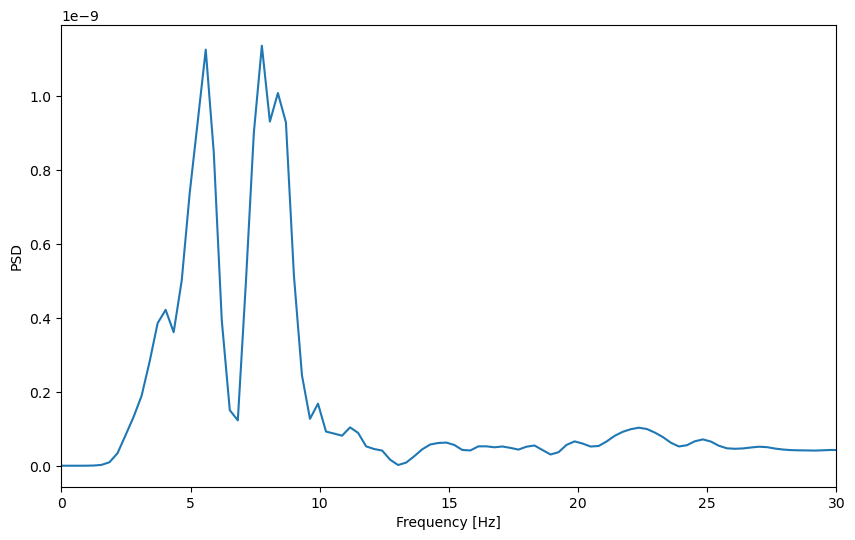

In [207]:

f, t, Sxx = signal.spectrogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'],window=('tukey', 0.1), nperseg=None, noverlap=None)
fff, Pxx = signal.periodogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'])


fig, axs = plt.subplots(figsize=(10,6))

plt.plot(fff,Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,30)

### Filtering

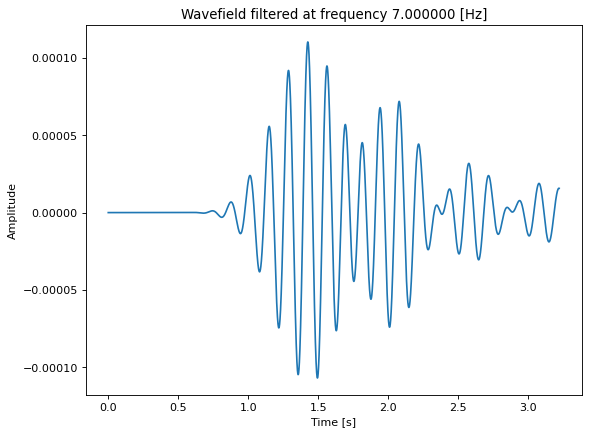

In [208]:
# Bandbass Filter
t = np.linspace(0,PARA['nt']*PARA['dt'], PARA['nt'])

nn = np.array([6])#([0.01]) 18 ###0.1
mm = np.array([8])#([70]) 25     ###6
f_BAND = np.array([nn,mm])


U_filt_Z = np.zeros((VEL_Z.shape[0],VEL_Z.shape[1], nrz, VEL_Z.shape[3],len(f_BAND[0,:])))

for dd in range(nrz):


        U_filterZ, f_filt_cent = BP_filter(VEL_Z[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        U_filt_Z[:,:,dd,:,:] = np.reshape(U_filterZ, (U_filt_Z[:,:,dd,:,:].shape))


nf = 0
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, U_filt_Z[posX,posY,posZ,:,nf])
plt.title('Wavefield filtered at frequency %f [Hz]' %np.round(f_filt_cent[nf],2))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show() 
    
ll = len(f_filt_cent)
    

In [209]:
AMP = np.zeros((nr,nr))

for l in range(0,nr): 
        for k in range(0,nr):

            AMP[l,k] = np.max( U_filt_Z[l,k,0,:,0])

### Subsampling

In [210]:
# Spatial Subsampling of true model
# Get velocity, density and attenuation fields at receiver points

rxx=nr
ryy=nr
rzz = nrz

grid_pos = 'full'

Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) ).tolist()
Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) ).tolist()
Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

vp_sub_INPUT     = ds_without_q.vp.values[:,:,Rz]
vp_sub_INPUT     = vp_sub_INPUT[Rx,:,:]
vp_sub_INPUT     = np.asarray(vp_sub_INPUT[:,Ry,:])

rho_grad_INPUT   = ds_without_q.rho.values[:,:,Rz]
rho_grad_INPUT   = rho_grad_INPUT[Rx,:,:]
rho_grad_INPUT   = np.asarray(rho_grad_INPUT[:,Ry,:])

vp_sub     = ds_without_q.vp.values[:,:,Rz] # model_true.VP[:,:,Rz].values
vp_sub     = vp_sub[Rx,:,:]
vp_sub     = np.asarray(vp_sub[:,Ry,:])

# vs_sub     = model_true.VS[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
# vs_sub     = vs_sub[Rx,:,:]
# vs_sub     = np.asarray(vs_sub[:,Ry,:])

rho_grad   = ds_without_q.rho.values[:,:,Rz] #model_true.RHO[:,:,Rz].values
rho_grad   = rho_grad[Rx,:,:]
rho_grad   = np.asarray(rho_grad[:,Ry,:])

if grid_pos =='half':
    
    Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) -1 ).tolist()
    Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) -1 ).tolist()
    Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

    Rxx= (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int)+1  ).tolist()
    Ryy= (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int)+1  ).tolist()
    
    rho_grad1   = ds_without_q.rho.values[:,:,Rz]
    rho_grad1   = rho_grad1[Rx,:,:]
    rho_grad1   = np.asarray(rho_grad1[:,Ry,:])

    rho_grad2   = ds_without_q.rho.values[:,:,Rz]#ds_without_q.rho[:,:,Rz] #model_true.RHO[:,:,Rz]
    rho_grad2   = rho_grad2[Rxx,:,:]
    rho_grad2   = rho_grad2[:,Ryy,:]
    rho_grad    = (rho_grad1.values+rho_grad2.values)/2

    vp_sub1     = ds_without_q.vp.values[:,:,Rz] #
    vp_sub1     = vp_sub1[Rx,:,:]
    vp_sub1     = np.asarray(vp_sub1[:,Ry,:])

    vp_sub2     = ds_without_q.vp.values[:,:,Rz] #
    vp_sub2     = vp_sub2[Rxx,:,:]
    vp_sub2     = np.asarray(vp_sub2[:,Ryy,:])
    vp_sub = (vp_sub1+vp_sub2)/2
    
if model =='acoustic':

    c_sub      = vp_sub 
    
else:
    c_sub      = 0.9*vs_sub




In [211]:
# Potential temporal subsampling
sub= 20         
nt_sub = np.ceil(PARA['nt']/sub).astype(int) 
dt_sub = sub* PARA['dt']
t_sub  = np.linspace(0,nt_sub*dt_sub, nt_sub)

#Potential spatial sampling
dx = PARA['dist_X']
dy = PARA['dist_Y']
dz = PARA['dist_Z']

sub_spXY = 2
dx = dx*sub_spXY
dy = dy*sub_spXY
sub_spZ  = 1
dz = dz*sub_spZ
dist_r=dist_r*sub_spXY
nr  = int(nr/sub_spXY)
rxx = int(rxx/sub_spXY)
ryy = int(ryy/sub_spXY)
nrz = int(nrz/sub_spZ)
rzz = int(rzz/sub_spZ)

  
u_field_Z =   U_filt_Z[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]
   

vp_subTRUE = vp_sub[:,:,:]   
rho_gradTRUE = rho_grad[:,:,:]
vp_sub = vp_sub[::sub_spXY,::sub_spXY,::sub_spZ]
c_sub = vp_sub
rho_grad = rho_grad[::sub_spXY,::sub_spXY,::sub_spZ]

if model=='elastic':
    vs_sub = vs_sub[::sub_spXY,::sub_spXY,::sub_spZ]


AMP = AMP[::sub_spXY,::sub_spXY]


In [212]:
rho_GRAD_X_true_scaled  = np.empty((nr, nr))
rho_GRAD_Y_true_scaled  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD_X_true_scaled[l, :] = 100*(rho_grad[l+1,:,0] - rho_grad[l-1,:,0])/(dist_r*2*rho_grad[l,:,0])
for k in range(1,nr-1):
                rho_GRAD_Y_true_scaled[:,k] = 100*(rho_grad[:,k+1,0] -  rho_grad[:,k-1,0])/(dist_r*2*rho_grad[:,k,0])
rho_GRAD_true_scaled = rho_GRAD_X_true_scaled + rho_GRAD_Y_true_scaled

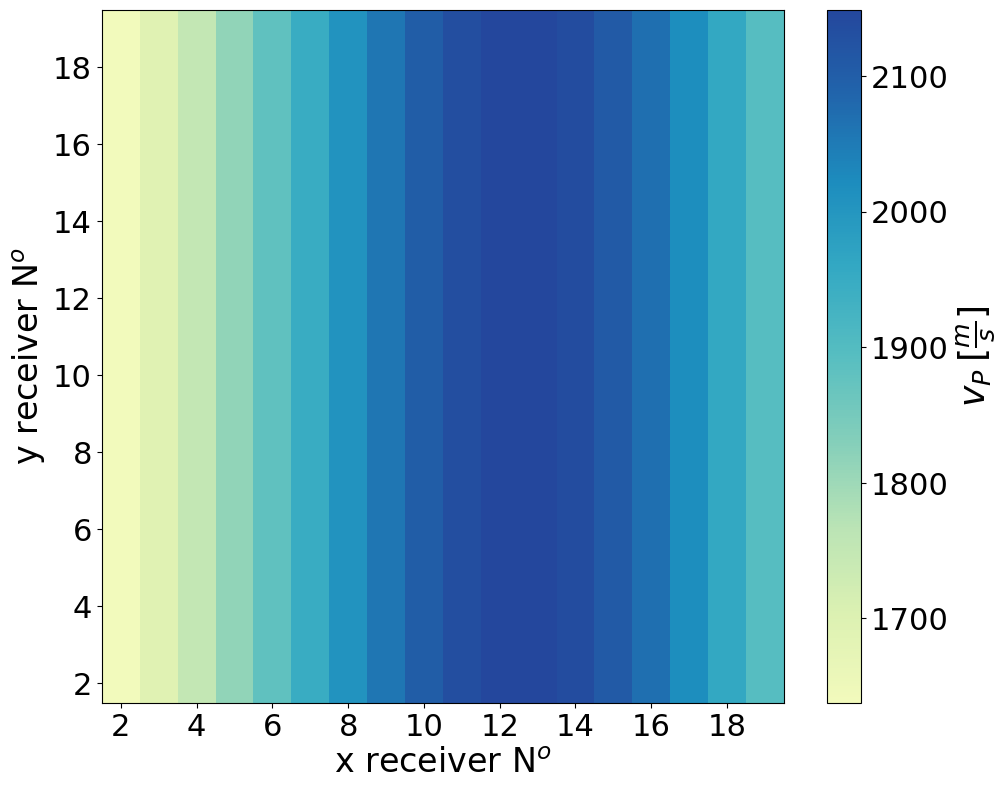

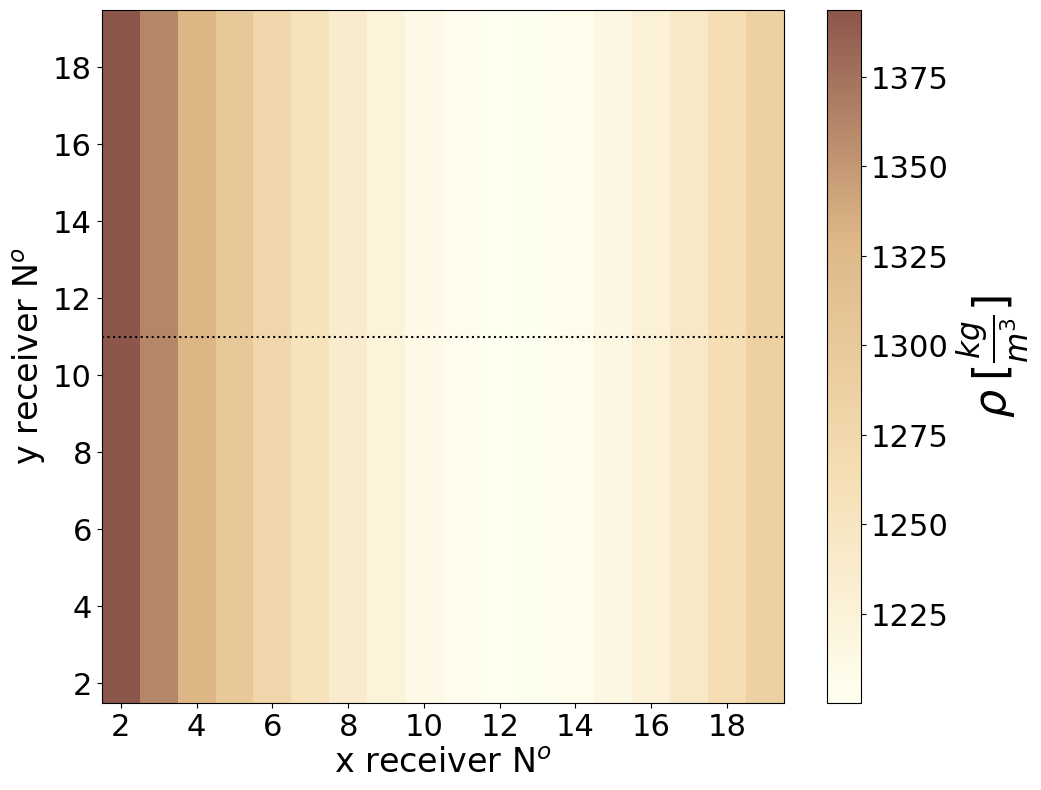

In [213]:
fig,ax = plt.subplots(figsize=(11,9))
#plt.title('True velocity',fontsize=16)
im=plt.imshow(vp_sub[1:-1,1:-1,0] ,vmin=np.min(vp_sub[1:-1,1:-1,0]), vmax=np.max(vp_sub[1:-1,1:-1,0]), aspect='auto', interpolation='none', cmap=YlGnBu ,origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im, format='%.0f')
cbar.set_label(label=r'$v_{P} \: [\frac{m}{s}]$',size=26)
plt.xlabel(r'x receiver N$^{o}$',fontsize=24)
plt.ylabel(r'y receiver N$^{o}$',fontsize=24)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
#start, end = ax.get_xlim()
#ax.xaxis.set_ticks(np.arange(start+0.5, end, 2))
ax.set_xticks([1,3,5,7,9,11,13,15,17])
ax.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax.set_yticks([1,3,5,7,9,11,13,15,17])
ax.set_yticklabels(['2','4','6','8','10','12','14','16','18'])

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(22)
plt.show() 

fig,ax = plt.subplots(figsize=(11,9))

#plt.title('True density',fontsize=16)
im2=plt.imshow(rho_grad[1:-1,1:-1,0] ,vmin=np.min(rho_grad[1:-1,1:-1,0]), vmax=np.max(rho_grad[1:-1,1:-1,0]), aspect='auto', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5], cmap=my_cmap)
plt.plot(np.linspace(0.5,nr-1.5,18),np.ones((18))*10,color='k', linestyle=':')
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label=r'$\rho \: [\frac{kg}{m^{3}}]$',size=32)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=24)
plt.ylabel(r'y receiver N$^{o}$',fontsize=24)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start+1.5, end, 2))
ax.set_xticks([1,3,5,7,9,11,13,15,17])
ax.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax.set_yticks([1,3,5,7,9,11,13,15,17])
ax.set_yticklabels(['2','4','6','8','10','12','14','16','18'])
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(22)
plt.show() 

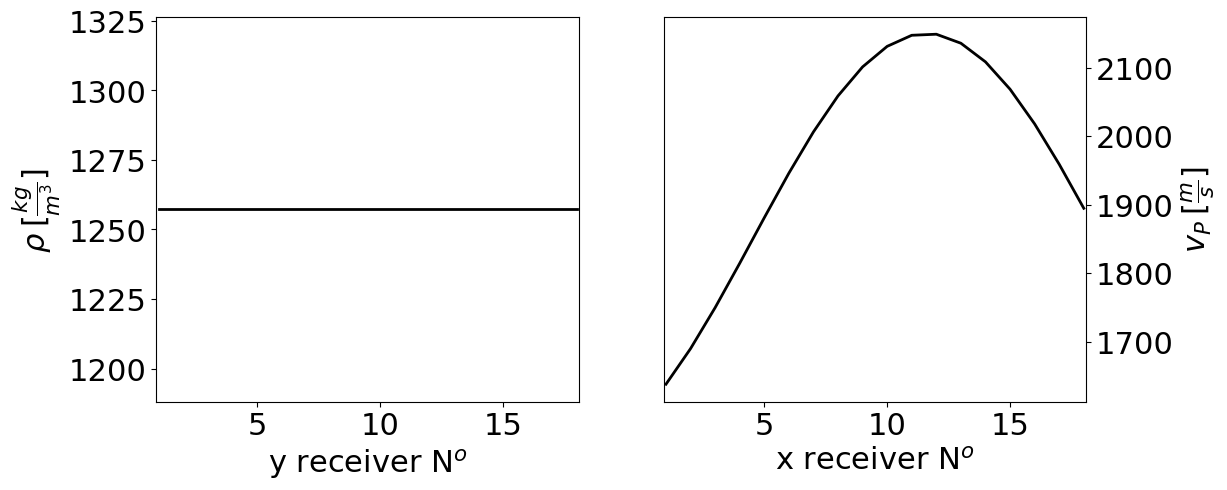

In [214]:
fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2)

ax1.plot(np.arange(1,nr-1),rho_grad[1:-1,1:-1,0].mean(axis=1).T.flatten(),linewidth=2, color='black')
ax2.plot(np.arange(1,nr-1),vp_sub[1:-1,1:-1,0].mean(axis=0).T.flatten(),linewidth=2, color='black')


ax1.set_xlim([1-0.1,(nr-1)-1+0.1])
ax2.set_xlim([1-0.1,(nr-1)-1+0.1])
ax1.set_ylabel(r'$\rho \: [\frac{kg}{m^{3}}]$',fontsize=22)
ax2.set_ylabel(r'$v_{P} \: [\frac{m}{s}]$',fontsize=22)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=22)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)

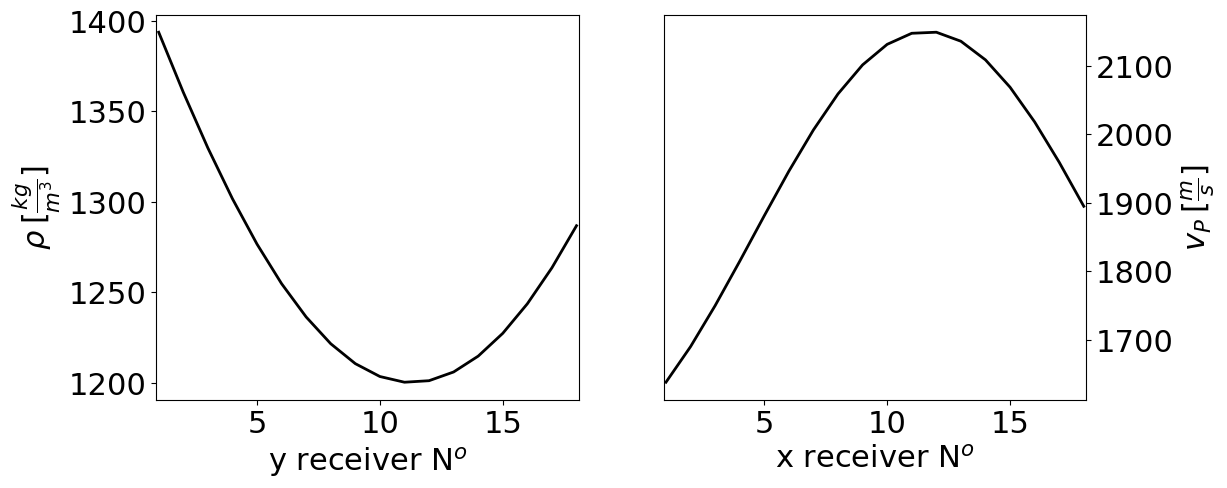

In [215]:
fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2)

ax1.plot(np.arange(1,nr-1),rho_grad[1:-1,1:-1,0].mean(axis=0).T.flatten(),linewidth=2, color='black')
ax2.plot(np.arange(1,nr-1),vp_sub[1:-1,1:-1,0].mean(axis=0).T.flatten(),linewidth=2, color='black')


ax1.set_xlim([1-0.1,(nr-1)-1+0.1])
ax2.set_xlim([1-0.1,(nr-1)-1+0.1])
ax1.set_ylabel(r'$\rho \: [\frac{kg}{m^{3}}]$',fontsize=22)
ax2.set_ylabel(r'$v_{P} \: [\frac{m}{s}]$',fontsize=22)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=22)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)

In [216]:
if model=='elastic':
    fig,ax = plt.subplots(figsize=(11,9))
    #plt.title('True velocity',fontsize=16)
    im=plt.imshow(lame1[1:-1,1:-1,0] ,vmin=np.min(lame1[1:-1,1:-1,0]), vmax=np.max(lame1[1:-1,1:-1,0]), aspect='auto', interpolation='none', cmap='RdYlBu' ,origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im, format="%4.1e")
    cbar.set_label(label=r'$\lambda$ [-]',size=26)
    plt.xlabel(r'x receiver N$^{o}$',fontsize=24)
    plt.ylabel(r'y receiver N$^{o}$',fontsize=24)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+1.5, end, 2))
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(22)
    plt.show() 

    fig,ax = plt.subplots(figsize=(11,9))

    #plt.title('True density',fontsize=16)
    im2=plt.imshow(lame2[1:-1,1:-1,0] ,vmin=np.min(lame2[1:-1,1:-1,0]), vmax=np.max(lame2[1:-1,1:-1,0]), aspect='auto',cmap='RdYlBu', interpolation='none',origin='lower', extent=[0.5,nr-2+0.5,0.5,nr-2+0.5])
    #plt.gca().invert_yaxis()
    cbar = plt.colorbar(im2, format="%4.1e")
    cbar.set_label(label=r'$\mu$ [-]',size=32)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
    plt.xlabel(r'x receiver N$^{o}$',fontsize=24)
    plt.ylabel(r'y receiver N$^{o}$',fontsize=24)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+1.5, end, 2))
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(22)
    plt.show() 

In [217]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 18}
# mpl.rc('font', **font)

if model=='elastic':
    fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2)

    ax1.plot(np.arange(1,nr-1),lame1[1:-1,1:-1,0].mean(axis=1).T.flatten(),linewidth=2, color='black')
    ax1.plot(np.arange(1,nr-1),lame1[1:-1,3,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax1.plot(np.arange(1,nr-1),lame1[1:-1,6,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax1.plot(np.arange(1,nr-1),lame1[1:-1,9,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax1.plot(np.arange(1,nr-1),lame1[1:-1,12,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax1.plot(np.arange(1,nr-1),lame1[1:-1,15,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax1.plot(np.arange(1,nr-1),lame1[1:-1,18,0].T.flatten(),linewidth=1, color='black',linestyle=':')

    ax2.plot(np.arange(1,nr-1),lame1[1:-1,1:-1,0].mean(axis=0).T.flatten(),linewidth=2, color='black')
    ax2.plot(np.arange(1,nr-1),lame1[3,1:-1,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax2.plot(np.arange(1,nr-1),lame1[6,1:-1,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax2.plot(np.arange(1,nr-1),lame1[9,1:-1,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax2.plot(np.arange(1,nr-1),lame1[12,1:-1,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax2.plot(np.arange(1,nr-1),lame1[15,1:-1,0].T.flatten(),linewidth=1, color='black',linestyle=':')
    ax2.plot(np.arange(1,nr-1),lame1[18,1:-1,0].T.flatten(),linewidth=1, color='black',linestyle=':')


    ax1.set_xlim([1-0.1,(nr-1)-1+0.1])
    ax2.set_xlim([1-0.1,(nr-1)-1+0.1])
    ax1.set_ylabel(r'$\lambda [-]$',fontsize=22)
    ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=22)
    ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=22)
    ax2.yaxis.tick_right()
    # ax1.xaxis.set_tick_params(labelsize=20)
    # ax1.yaxis.set_tick_params(labelsize=20)
    # ax2.xaxis.set_tick_params(labelsize=20)
    # ax2.yaxis.set_tick_params(labelsize=20)
    ax1.xaxis.set_tick_params(labelsize=22)
    ax2.yaxis.set_tick_params(labelsize=22)
    
    fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2)

    ax1.plot(np.arange(1,nr-1),np.gradient(lame1[1:-1,1:-1,0].mean(axis=1).T.flatten()),linewidth=2, color='black')
    ax2.plot(np.arange(1,nr-1),np.gradient(lame1[1:-1,1:-1,0].mean(axis=0).T.flatten()),linewidth=2, color='black')

    ax1.set_xlim([1-0.1,(nr-1)-1+0.1])
    ax2.set_xlim([1-0.1,(nr-1)-1+0.1])
    ax1.set_ylabel(r'$\lambda [-]$',fontsize=22)
    ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=22)
    ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=22)
    ax1.set_ylabel(r'$\frac{\partial \lambda}{\partial y} \: [-]$',fontsize=22)
    ax2.set_ylabel(r'$\frac{\partial \lambda}{\partial x} \: [-]$',fontsize=22)
    ax2.yaxis.tick_right()
    # ax1.xaxis.set_tick_params(labelsize=20)
    # ax1.yaxis.set_tick_params(labelsize=20)
    # ax2.xaxis.set_tick_params(labelsize=20)
    # ax2.yaxis.set_tick_params(labelsize=20)
    ax1.xaxis.set_tick_params(labelsize=22)
    ax2.yaxis.set_tick_params(labelsize=22)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

In [218]:
rho_GRAD_X_true_scaled  = np.empty((nr, nr))
rho_GRAD_Y_true_scaled  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD_X_true_scaled[l, :] = 100*(rho_grad[l+1,:,0] - rho_grad[l-1,:,0])/(dist_r*2*rho_grad[l,:,0])
for k in range(1,nr-1):
                rho_GRAD_Y_true_scaled[:,k] = 100*(rho_grad[:,k+1,0] -  rho_grad[:,k-1,0])/(dist_r*2*rho_grad[:,k,0])
rho_GRAD_true_scaled = rho_GRAD_X_true_scaled + rho_GRAD_Y_true_scaled

In [219]:
vp_GRAD_X_true_scaled  = np.empty((nr, nr))
vp_GRAD_Y_true_scaled  = np.empty((nr, nr))

for l in range(1,nr-1):
                vp_GRAD_X_true_scaled[l, :] = 100*(vp_sub[l+1,:,0] - vp_sub[l-1,:,0])/(dist_r*2*vp_sub[l,:,0])
for k in range(1,nr-1):
                vp_GRAD_Y_true_scaled[:,k] = 100*(vp_sub[:,k+1,0] -  vp_sub[:,k-1,0])/(dist_r*2*vp_sub[:,k,0])
vp_GRAD_true_scaled = vp_GRAD_X_true_scaled + vp_GRAD_Y_true_scaled

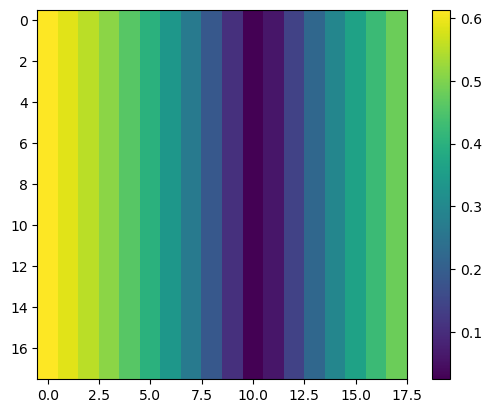

In [220]:
im = plt.imshow(abs(rho_GRAD_true_scaled[1:-1,1:-1]))
plt.colorbar(im)

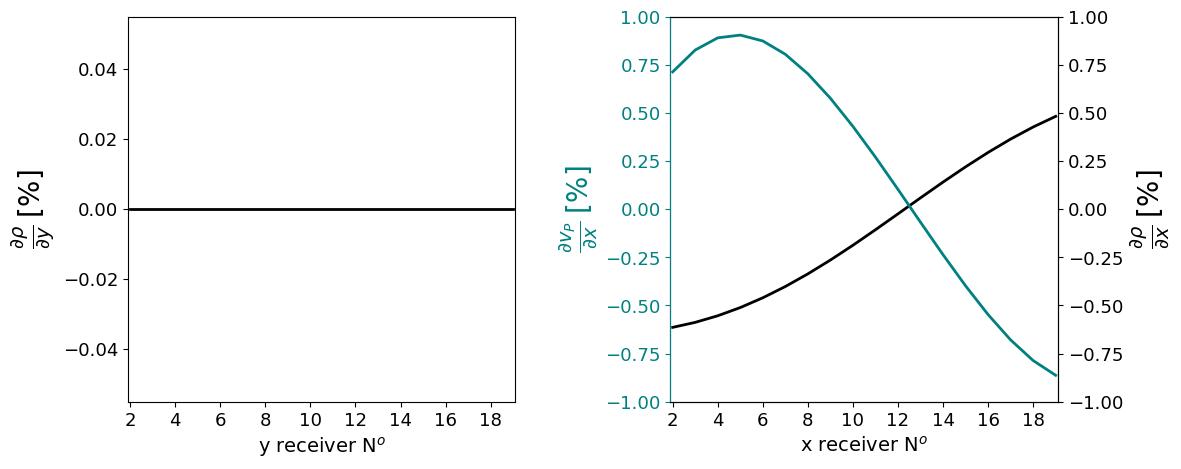

In [224]:
fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2,  gridspec_kw={'wspace': 0.4})

ax2.plot(np.arange(1,nr-1),((rho_GRAD_Y_true_scaled[1:-1,1:-1]).mean(axis=0)),linewidth=2, color='black')

ax=ax2.twinx()
ax.plot(np.arange(1,nr-1),(vp_GRAD_Y_true_scaled[1:-1,1:-1]).mean(axis=0),linewidth=2, color='teal')

ax1.plot(np.arange(1,nr-1),((rho_GRAD_X_true_scaled[1:-1,1:-1]).mean(axis=1)),linewidth=2, color='black')



ax1.set_xlim([1-0.1,(nr-1)-1+0.1])
ax2.set_xlim([1-0.1,(nr-1)-1+0.1])
ax.set_ylabel(r'$\frac{\partial v_{P}}{\partial x} \: [\%]$',fontsize=20)
ax2.set_ylabel(r'$\frac{\partial \rho}{\partial x} \: [\%]$',fontsize=20)
ax1.set_ylabel(r'$\frac{\partial \rho}{\partial y} \: [\%]$',fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")


ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=14)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=14)

# ax2.set_ylim([-2.8,2.8])
# ax.set_ylim([-2.8,2.8])
ax2.set_ylim([-1,1])
ax.set_ylim([-1,1])

ax2.tick_params(axis='y', labelsize= 13)
ax1.tick_params(axis='y', labelsize= 13)
ax.tick_params(axis='y', labelsize= 13)

ax2.tick_params(axis='x', labelsize= 13)
ax2.set_xticks([1,3,5,7,9,11,13,15,17])
ax2.set_xticklabels(['2','4','6','8','10','12','14','16','18'])
ax1.tick_params(axis='x', labelsize= 13)
ax1.set_xticks([1,3,5,7,9,11,13,15,17])
ax1.set_xticklabels(['2','4','6','8','10','12','14','16','18'])

ax.spines['left'].set_color('teal')
ax.tick_params(axis='y', colors='teal')
ax.yaxis.label.set_color('teal')

Text(0.5, 0, 'x receiver N$^{o}$')

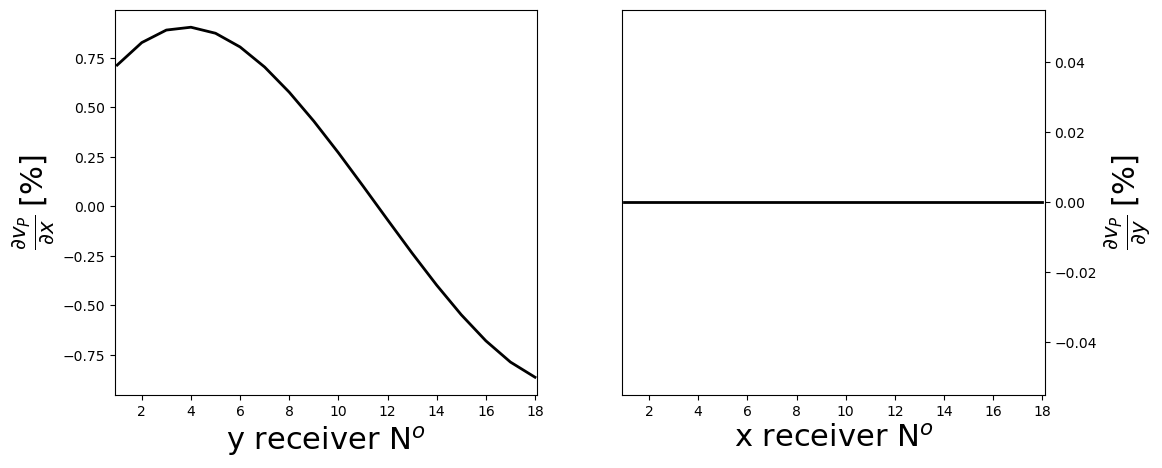

In [222]:
fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2)

ax1.plot(np.arange(1,nr-1),(vp_GRAD_Y_true_scaled[1:-1,1:-1]).mean(axis=0),linewidth=2, color='black')
ax2.plot(np.arange(1,nr-1),(vp_GRAD_X_true_scaled[1:-1,1:-1]).mean(axis=0),linewidth=2, color='black')


ax1.set_xlim([1-0.1,(nr-1)-1+0.1])
ax2.set_xlim([1-0.1,(nr-1)-1+0.1])
ax1.set_ylabel(r'$\frac{\partial v_{P}}{\partial x} \: [\%]$',fontsize=22)
ax2.set_ylabel(r'$\frac{\partial v_{P}}{\partial y} \: [\%]$',fontsize=22)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=22)

In [223]:
plt.plot(lame1[2,:,0].flatten())
plt.plot(lame1[8,:,0].flatten())
plt.plot(lame1[15,:,0].flatten())

NameError: name 'lame1' is not defined

In [ ]:
plt.plot(lame1[:,2,0].flatten())
plt.plot(lame1[:,8,0].flatten())
plt.plot(lame1[:,15,0].flatten())

In [ ]:
np.arange(Rx[::sub_spXY][0],Rx[::sub_spXY][-1]+1,dist_r)

In [ ]:
subi=1
fig,ax=plt.subplots(figsize=(18,8))
im = plt.imshow(model_true.VP[300,:,::-1].T, cmap = cmap4)
plt.title('Velocity Model \n', fontsize = 24)
#plt.colorbar(label='[m/s]',size=18)
cbar = plt.colorbar(im, pad=0.02)
cbar.set_label(label=r'$v_{P} \: [\frac{m}{s}]$',size=24)
plt.xlabel('x-direction [m]', fontsize=22)
plt.ylabel('Depth z [m]', fontsize=22)
#plt.scatter(np.arange(295,305,1),np.ones(10)*2, color='crimson', s=20, marker='o')
#plt.scatter(np.arange(Rx[::sub_spXY*subi][0],Rx[::sub_spXY*subi][-1]+1,dist_r*subi),-np.ones(int(40/(sub_spXY*subi)))*6, color='crimson', s=350, marker=',', clip_on=False)
plt.scatter(np.arange(Rx[::sub_spXY*subi][0],Rx[::sub_spXY*subi][-1]+1,dist_r*subi),-np.ones(int(40/(sub_spXY*subi)))*6, color='crimson', s=200, marker='v', clip_on=False)

plt.scatter(10,10,marker='*',color='darkviolet',s=800, clip_on=False)
plt.scatter(590,10,marker='*',color='darkviolet',s=800, clip_on=False)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
ax.set_ylim([300,0])
plt.show()

In [ ]:
#fontname="DejaVu Sans"
fig,ax=plt.subplots(figsize=(18,8))
im = plt.imshow(model_true.RHO[:,300,::-1].T, cmap=cmap3)
plt.title('Density Model \n', fontsize = 24)
#plt.colorbar(label='[m/s]',size=18)
cbar = plt.colorbar(im, pad=0.02)
cbar.set_label(label=r'$\rho \: [\frac{kg}{m^{3}}]$',size=30)
plt.xlabel('y-direction [m]', fontsize=22)
plt.ylabel('Depth z [m]',  fontsize=22)
#plt.scatter(np.arange(295,305,1),np.ones(10)*2, color='crimson', s=20, marker='o')
#plt.scatter(np.arange(300-47.5+dist_r,300+47.5-dist_r,dist_r),np.ones(8)*2, color='crimson', s=20, marker='o')
plt.scatter(np.arange(Rx[::sub_spXY][0],Rx[::sub_spXY][-1]+1,dist_r),-np.ones(int(40/sub_spXY))*6, color='crimson', s=200, marker='v', clip_on=False)
#plt.scatter(np.arange(Rx[::sub_spXY][0],Rx[::sub_spXY][-1]+1,dist_r),np.ones(int(40/sub_spXY))*2, color='crimson', s=20, marker='o')
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
#plt.scatter(10,10,marker='*',color='darkviolet',s=800)
#plt.scatter(590,10,marker='*',color='darkviolet',s=800)
#plt.scatter(300,0, color='crimson', s=100, marker='^')
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
ax.set_ylim([300,0])
plt.show()

In [ ]:
posZ=0
title = 'Velocity Field - Z component'
text1 = 'Vp at depth = %d m'%(posZ*dz +dz)
text2 = 'Vp at time t'
OUT_Z     = np.reshape(OUT.Pressure.data, (nrx*sub_spXY,nry*sub_spXY,nrz*sub_spZ,PARA['nt']))

fs_est = VEL_Z[:,:,posZ,::sub].sum(2)
fp_est = VEL_Z[:,:,posZ,100]
nr_internal = nr-order

I=1
label_name= 'field'
colormap='viridis'
image_field(_res, fp_est, fs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2,I, label_name, colormap)

In [ ]:
posZ=0
text1 = 'Temporal grads'#'Vp at depth = %d m'%(posZ*dz +dz)
text2 = 'Spatial grads'#'Vs at depth = %d m'%(posZ*dz +dz)
# OUT_Z     = np.reshape(OUT.Pressure.data, (nrx*sub_spXY,nry*sub_spXY,nrz*sub_spZ,PARA['nt']))
OUT_Z     = np.reshape(U_filt_Z[:,:,:,::sub], (nrx*sub_spXY,nry*sub_spXY,nrz*sub_spZ,nt_sub))

fs_est = acc3_2D[:,:,posZ,1:-1,0].sum(2)#VEL_Z[:,:,posZ,::sub].sum(2)
fp_est = dttv3[:,:,posZ,1:-1,0].sum(2)#VEL_Z[:,:,posZ,::sub].sum(2)
nr_internal = nr-order

I=1
label_name= 'field'
colormap='viridis'
image_field(_res, fp_est, fs_est, title, nr_internal, rx0+dx, rx1-dx, ry0+dy, ry1-dy, text1, text2,I, label_name, colormap)

In [ ]:
###ERROR PLOT

In [ ]:
import seaborn as sns
palette = sns.color_palette("Blues", 10).as_hex()
print(palette)
ccc=['#e5eff9', '#d3e4f3', '#bfd8ed', '#a1cbe2', '#7db8da', '#5ca4d0', '#3f8fc5', '#2676b8', '#135fa7', '#08488e']

vir=LinearSegmentedColormap.from_list("mycmap", ccc)

In [ ]:
c_min = 100#1550 
f = np.linspace(1,20,200)#np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])#,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,40,50,60,70,80,90,95,100,110,120])
lam = c_min/f
dx_list = [1,2,4,8,12,16,20]

err = np.zeros((len(dx_list),len(f)))
i=0
for i in range(0,len(dx_list)):
    err[i,:] = 100 * ( (dx_list[i]**2) * (2 * np.pi)**2 ) / (24 * (lam)**2)


In [ ]:
err_acc = 0.1
dx_limit = np.sqrt(err_acc* 24 * lam**2 / (2*np.pi)**2)
dx_limit_perc = dx_limit/lam
#dx_limit_perc

In [ ]:
args=np.argwhere(err[2,:]>10)
f[args]
fraction[args]
#args


In [ ]:
lam[args[0]-1][0]

In [ ]:
fraction = np.round(1/(dx_list[2]/lam),1)

#for i in range(0,len(dx_list)):
fig, ax = plt.subplots(figsize=(8,6))
#plt.plot(f,err[0,:], color=ccc[0], label=r'dx=1; $\lambda $/'+str((1/(dx_list[0]/lam[0])).astype(int)))
#plt.plot(f,err[1,:], color=ccc[1], label=r'dx=2; $\lambda $/'+str((1/(dx_list[1]/lam[1])).astype(int)))
plt.plot(f,err[2,:], color='blue', label=r'dx=4')# $\lambda $/'+str((1/(dx_list[2]/lam[2])).astype(int)))
#plt.plot(f,err[3,:], color=ccc[3], label='dx=8')
#plt.plot(f,err[4,:], color=ccc[4], label='dx=12')
#plt.plot(f,err[5,:], color=ccc[5], label='dx=16')
plt.ylabel('Finite Difference Error [%]', fontsize=14)
plt.xlabel('Frequencies [Hz]', fontsize=14)
plt.plot(f,np.ones((len(f)))*10, linestyle=':',color='black')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#plt.scatter(300,0, color='crimson', s=100, marker='^')
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
plt.xlim([f[0],f[-1]])
ax.legend(fontsize=14,loc='upper left', ncol=1)

plt.scatter(f[args[0]-1],err[2,args[0]-1], marker='*', s=400, color='gold')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.65,'Minimum medium velocity: \n'+str(c_min)+' [m/s] ', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.05, 0.5,'Threshold frequency: \n'+str(np.round(f[args[0]-1][0],1))+' [Hz] ', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.05, 0.35,'Sampling criterion: \n'+r' $\lambda$/'+str(np.round(fraction[args[0]-1][0],0)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

In [ ]:
plt.plot(fraction,f)

In [ ]:
#for i in range(0,len(dx_list)):

fig, ax = plt.subplots(figsize=(8,6))
#plt.plot(f,err[0,:], color=ccc[0], label=r'dx=1; $\lambda $/'+str((1/(dx_list[0]/lam[0])).astype(int)))
#plt.plot(f,err[1,:], color=ccc[1], label=r'dx=2; $\lambda $/'+str((1/(dx_list[1]/lam[1])).astype(int)))
plt.plot(fraction[:],err[2,:], color=ccc[2], label=r'dx=4')#; $\lambda $/'+str((1/(dx_list[2]/lam[2])).astype(int)))
#plt.plot(f,err[3,:], color=ccc[3], label='dx=8')
#plt.plot(f,err[4,:], color=ccc[4], label='dx=12')
#plt.plot(f,err[5,:], color=ccc[5], label='dx=16')
#plt.ylabel('Error [%]', fontsize=14)
plt.xlabel('Fraction of $\lambda$', fontsize=14)
plt.plot(fraction,np.ones((len(f)))*10, linestyle=':',color='black')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#plt.scatter(300,0, color='crimson', s=100, marker='^')
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
plt.xlim([fraction[0],fraction[-1]])
ax.legend(fontsize=12,loc='upper left', ncol=1)
#ax.set_xscale('log')
#plt.xticks(fraction)
plt.show()

In [ ]:
lam

In [ ]:
#for i in range(0,len(dx_list)):
fig, ax = plt.subplots(figsize=(8,6))
#plt.plot(lam,err[0,:], color=ccc[0], label='dx=1')
#plt.plot(lam,err[1,:], color=ccc[1], label='dx=2')
plt.plot(lam,err[2,:], color=ccc[2], label='dx=4')
#plt.plot(lam,err[3,:], color=ccc[3], label='dx=8')
#plt.plot(lam,err[4,:], color=ccc[4], label='dx=12')
#plt.plot(lam,err[5,:], color=ccc[5], label='dx=16')
plt.ylabel('Error [%]', fontsize=14)
plt.xlabel('Wavelength [m]', fontsize=14)
plt.plot(lam,np.ones((len(lam)))*10, linestyle=':',color='black')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#plt.scatter(300,0, color='crimson', s=100, marker='^')
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
plt.xlim([60,15])
ax.legend(fontsize=12,loc='upper left', ncol=1)
plt.show()

In [ ]:
4/17

In [ ]:
f

In [ ]:
plt.plot(err[2,0:14],f[0:14] ,color='black',linestyle=':',linewidth=2)
plt.scatter(err[2,0:14],f[0:14] ,color='black',marker='+',s=200,linewidth=2)
plt.ylabel('Error [%]', fontsize=14)
plt.xlabel('Frequencies [Hz]', fontsize=14)

In [ ]:
to_export = pd.DataFrame(err)
to_export.to_csv(fig_+'/FD_err', index=False)

In [ ]:
plt.plot(f,err[2,:], color=ccc[2], label='dx=4')


In [ ]:
err[2,-1]

In [ ]:
f[-1]

In [ ]:
c_min = 1550 
f = np.array([30,40,50,60,70,80,90,100])#,50,100])
lam = c_min/f
dx_list = [1,2,4,8,12,16,20]

err = np.zeros((len(dx_list),len(f)))
i=0
for i in range(0,len(dx_list)):
    err[i,:] = 100 * ( (dx_list[i]**2) * (2 * np.pi)**2 ) / (24 * (lam)**2)


In [ ]:
err[2,-1]